# PIC 16A Final Project - Predicting Spam Emails
## Olivia Weisiger, Madeline Chew, Yanming (Steven) Chen

### Preliminary Steps

In [1]:
# Loading required packages
import pandas as pd
# m pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# This cell imports your functions defined in FinalProjectFunctions.py 
# from myFinalProjectFunctions import get_common_words, text_to_dict 
from FinalProjectFunctions import isSpam, graphMispellings, text_process

In [2]:
# Reading the data
# Spam = 1; not = 0
email_data = pd.read_csv("spam_ham_dataset.csv")
email_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


We can see that our data was loaded correctly and is comprised of a label ('spam' or 'ham'), text (subject and body of the email), and a label number (1 = spam; 0 = ham).

## Spam vs Ham Data Exploration

### Mispelling Frequency Plots

First, we will create separate text column lists depending on if the email was labeled as 'spam' or 'ham'.

In [3]:
#initialize empty lists to store the spam and ham email texts
spamEmails = []
hamEmails = []

#iterate through the dataset of email text
for i in range(len(email_data[0:24])):
    #if the dataset's email is labeled as 'spam' append to spamEmails list
    if email_data['label'][i] == 'spam' :
        spamEmails.append(email_data['text'][i])
    #if the dataset's email is labeled as 'ham' append to hamEmails list
    else :
        hamEmails.append(email_data['text'][i])
        
#change lists to panda series to put into the class
# **Only taking first 25 for efficiency purposes**
spamSet = pd.Series(spamEmails)
hamSet = pd.Series(hamEmails)

#make instances of class isSpam for the spam and ham datasets
spamSet = isSpam(spamSet)
hamSet = isSpam(hamSet)

#call the get_mispelled_words() function to get a list of the number of mispelled words
spamList = spamSet.get_mispelled_words()[1]
hamList = hamSet.get_mispelled_words()[1]

#call the get_mispelling_duplicates() function to get a list of the number of repeated mispelled words
spamListRepeated = spamSet.get_mispelling_duplicates()[1]
hamListRepeated = hamSet.get_mispelling_duplicates()[1]

<AxesSubplot:xlabel='Emails', ylabel='# of Mispellings'>

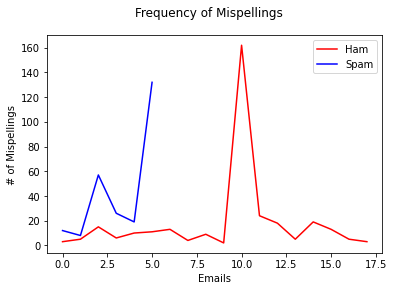

In [4]:
# use the graphMispellings() function to compare the amount of mispellings in spam vs ham emails
graphMispellings(spamList, hamList)

From the graph, we can see spam emails tend to have a higher number of mispellings compared to ham emails, so it would be a relevant variable to use to predict if an email is spam or ham.

<AxesSubplot:xlabel='Emails', ylabel='# of Mispellings'>

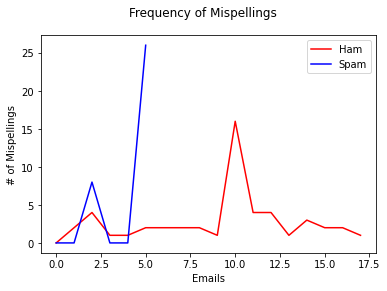

In [5]:
# use the graphMispellings() function to compare the amount of repeated mispellings in spam vs ham emails
graphMispellings(spamListRepeated, hamListRepeated)

From the graph, we can see spam emails tend to have a higher number of repeatedmispellings compared to ham emails, so it would be a relevant variable to use to predict if an email is spam or ham.

Using a similar method to creating the `spamSet` and `hamSet` instances above, we will construct a word cloud of the most common words used in 'spam' vs 'ham' emails.

### Common Words - Word Cloud

#### Preparing Text Input to Create the Word Clouds

In [6]:
#initialize empty lists to store the spam and ham email texts
spamEmails = []
hamEmails = []

#iterate through the dataset of email text
for i in range(len(email_data)):
    #if the dataset's email is labeled as 'spam' append to spamEmails list
    if email_data['label'][i] == 'spam' :
        spamEmails.append(email_data['text'][i])
    #if the dataset's email is labeled as 'ham' append to hamEmails list
    else :
        hamEmails.append(email_data['text'][i])
        
#change lists to panda series to put into the class
full_spamSet = pd.Series(spamEmails)
full_hamSet = pd.Series(hamEmails)

#make instances of class isSpam for the spam and ham datasets
full_spamSet = isSpam(full_spamSet)
full_hamSet = isSpam(full_hamSet)

#call the get_common_words(1) function to get a list of the most frequntly occuring words
full_spamList = full_spamSet.get_common_words(1)
full_hamList = full_hamSet.get_common_words(1)

# Isolate spam/ham words from their occurence frequency and create list
all_spam_words = [[word[0] for word in pair] for pair in full_spamList]
all_ham_words = [[word[0] for word in pair] for pair in full_hamList]

# join most common spam words into one string
spam_text = " ".join([item for sublist in all_spam_words for item in sublist])

# join most common ham words into one string
ham_text = " ".join([item for sublist in all_ham_words for item in sublist])

#### Creating the Word Clouds

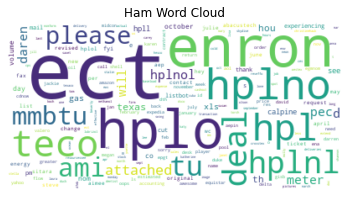

In [7]:
# Creating word_cloud with text as argument in .generate() method
word_cloud_HAM = WordCloud(collocations = False, background_color = 'white').generate(ham_text)
# Display the generated Word Cloud
plt.imshow(word_cloud_HAM, interpolation='bilinear')
plt.title("Ham Word Cloud")
plt.axis("off")
plt.show()

From the ham word cloud, we can see that our man-built `get_common_words()` function allows for many typos and stop words, which when building a model, we hope to avoid. Many of the words appear to be nonsense, despite the fact that these are the most commonly occuring words in the ham emails.

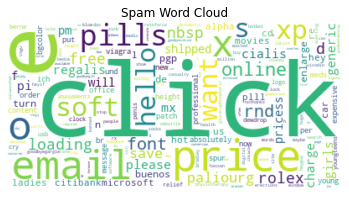

In [8]:
# Creating word_cloud with text as argument in .generate() method
word_cloud_SPAM = WordCloud(collocations = False, background_color = 'white').generate(spam_text)
# Display the generated Word Cloud
plt.imshow(word_cloud_SPAM, interpolation='bilinear')
plt.title("Spam Word Cloud")
plt.axis("off")
plt.show()

Comparatively, from the spam word cloud, we surprisingly see that the most commonly used words appear to be less nonsensical than those in the ham word cloud. We can see that the most commonly used word across all spam emails is 'click', which makes sense in the context of advertising to individuals through spam emails, and wanting them to interact/react to the material.

#### Removing Stop Words

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.  We choose to eliminate these words that carry very little useful information. 

In [9]:
df = email_data
y = df['label_num']
x = df['text'].apply(text_process) # pandas apply, a little faster than basic for loop

### Creating A Model

From our exploration, we discovered that counting commonly used words and mispelling words can be time-consuming when vectorizing the email texts for prediction. So, after removing stopwords, we used TF-IDF vectorization to transform the text data to numerical vectors.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(x)
vectors.shape

(5171, 50342)

For candidate models, we chose Logistic Regression, Support Vector Machine, Multinomial Naive Bayes, Decision Tree, Random Forests, and K-Neighbors for our classification task. 

In [11]:
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
X_train, X_test, y_train, y_test = train_test_split(vectors, y, test_size=0.2, random_state=1024)

The following hyperparameters have good performance:

In [13]:
svc = SVC(kernel='sigmoid', gamma=0.1)
knc = KNeighborsClassifier(n_neighbors=30)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=1024)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=15, random_state=1024)

Compare the performance of different models:

In [14]:
clfs = {'SVC' : svc,'K-Neighbors' : knc, 'Multinomial NB': mnb, 'Decision Tree': dtc, 'Linear Reg': lrc, 'Random Forest': rfc}

In [21]:
# Use two simple functions for more compactness
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [22]:
# Put the scores in a list to view
pred_scores = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores.append((k, accuracy_score(y_test , pred)))

In [17]:
pred_scores

[('SVC', 0.9806763285024155),
 ('K-Neighbors', 0.9642512077294686),
 ('Multinomial NB', 0.9758454106280193),
 ('Decision Tree', 0.9468599033816425),
 ('Linear Reg', 0.9458937198067633),
 ('Random Forest', 0.9623188405797102)]

From the prediction scores, we found that Support Vector Classifier is the best model for this dataset.

### Play around with the models

In [18]:
def check(text, pred):
    for i in range(len(pred)):
        if pred[i] == 1:
            print ("SPAM" + ": " + text[i] + '\n')
        else:
            print ("NOT Spam" + ": " + text[i] + '\n')

In [23]:
# Try on some new texts
# Use svc, support vector classifier for prediction
new_text = [df['text'][0], df['text'][1], df['text'][3],'USC can beat UCLA']
input_test = vectorizer.transform(new_text)
output_test = predict(svc, input_test)
check(new_text, output_test)

NOT Spam: Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

NOT Spam: Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls

SPAM: Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin


SPAM: USC can beat UCLA



In [26]:
# Try a different model
# mnb gets a non-friendly prediction saying USC beat UCLA is not spam
output_test = predict(mnb, input_test) 
check(new_text, output_test)

NOT Spam: Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

NOT Spam: Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls

SPAM: Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin


NOT Spam: USC can beat UCLA

